In [ ]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

def load_sweep_results_grid(sweep_dir: str, k_values: list, hidden_dims: list):
    """
    Load sweep results and organize into a grid for heatmap visualization.
    
    Args:
        sweep_dir: Path to the sweep directory
        k_values: List of k (sequence length) values
        hidden_dims: List of hidden dimension values
        
    Returns:
        grid: 2D numpy array with shape (len(hidden_dims), len(k_values))
              containing mean final train losses
        std_grid: 2D numpy array with standard deviations (if multiple seeds)
    """
    sweep_path = Path(sweep_dir)
    
    # Initialize grids
    grid = np.full((len(hidden_dims), len(k_values)), np.nan)
    std_grid = np.full((len(hidden_dims), len(k_values)), np.nan)
    
    # Load results for each experiment
    for i, h in enumerate(hidden_dims):
        for j, k in enumerate(k_values):
            exp_name = f"k{k}_h{h}"
            exp_dir = sweep_path / exp_name
            
            if not exp_dir.exists():
                print(f"Warning: Experiment {exp_name} not found")
                continue
            
            # Load experiment summary
            summary_file = exp_dir / "experiment_summary.yaml"
            if summary_file.exists():
                with open(summary_file, 'r') as f:
                    summary = yaml.safe_load(f)
                
                # Get mean train loss
                if 'train_loss_stats' in summary:
                    grid[i, j] = summary['train_loss_stats']['mean']
                    std_grid[i, j] = summary['train_loss_stats']['std']
                else:
                    print(f"Warning: No train_loss_stats in {exp_name}")
            else:
                print(f"Warning: No summary file for {exp_name}")
    
    return grid, std_grid


## 1D Analysis Functions

Analyze individual 1D experiments from the sweep with detailed power spectrum and neuron specialization plots.


In [ ]:
import torch
import numpy as np
from pathlib import Path
from gagf.rnns.utils import (
    plot_prediction_power_spectrum_over_time_1d,
    plot_wout_neuron_specialization_1d,
    plot_model_predictions_over_time_1d,
    topk_template_freqs_1d,
)
from gagf.rnns.model import SequentialMLP

def analyze_1d_experiment(sweep_dir, exp_name, seed=0, num_freqs_to_track=10):
    """
    Analyze a single 1D experiment from the sweep.
    
    Args:
        sweep_dir: Path to sweep directory
        exp_name: Experiment name (e.g., "k3_h360")
        seed: Seed number to analyze
        num_freqs_to_track: Number of top frequencies to track
        
    Returns:
        Dictionary with analysis results
    """
    # Setup paths
    sweep_path = Path(sweep_dir)
    exp_dir = sweep_path / exp_name / f"seed_{seed}"
    
    if not exp_dir.exists():
        print(f"Experiment directory not found: {exp_dir}")
        return None
    
    print(f"Analyzing: {exp_name}, seed {seed}")
    print(f"Directory: {exp_dir}")
    
    # Load config
    with open(exp_dir / "config.yaml", 'r') as f:
        config = yaml.safe_load(f)
    
    # Load template
    template = np.load(exp_dir / "template.npy")
    p = len(template)
    k = config['data']['k']
    hidden_dim = config['model']['hidden_dim']
    
    print(f"  p={p}, k={k}, hidden_dim={hidden_dim}")
    
    # Load training history
    train_loss_hist = np.load(exp_dir / "train_loss_history.npy")
    param_hist = torch.load(exp_dir / "param_history.pt", map_location='cpu')
    
    # Create model
    device = 'cpu'
    template_torch = torch.tensor(template, dtype=torch.float32, device=device)
    model = SequentialMLP(
        p=p,
        d=hidden_dim,
        template=template_torch,
        k=k,
        init_scale=config['model']['init_scale'],
        return_all_outputs=config['model']['return_all_outputs'],
    ).to(device)
    
    # Generate evaluation data
    from gagf.rnns.datamodule import build_modular_addition_sequence_dataset_1d
    X_data, Y_data, _ = build_modular_addition_sequence_dataset_1d(
        p, template, k,
        mode='sampled',
        num_samples=1000,
        return_all_outputs=config['model']['return_all_outputs'],
    )
    X_data_t = torch.tensor(X_data, dtype=torch.float32, device=device)
    Y_data_t = torch.tensor(Y_data, dtype=torch.float32, device=device)
    
    # Get tracked frequencies
    tracked_freqs = topk_template_freqs_1d(template, K=num_freqs_to_track)
    colors = plt.cm.tab10(np.linspace(0, 1, len(tracked_freqs)))
    
    # Checkpoints to analyze
    checkpoint_indices = [0, len(param_hist)//4, len(param_hist)//2, 
                          3*len(param_hist)//4, len(param_hist)-1]
    
    # Plot 1: Power spectrum over time
    print("\\n  Plotting power spectrum analysis...")
    fig1, _, _, _ = plot_prediction_power_spectrum_over_time_1d(
        model, param_hist, X_data_t, Y_data_t, template, p,
        loss_history=train_loss_hist,
        num_freqs_to_track=num_freqs_to_track,
        num_samples=100,
        save_path=exp_dir / "power_spectrum_analysis_1d.pdf",
        show=True
    )
    
    # Plot 2: Model predictions over time
    print("  Plotting predictions over time...")
    fig2, _ = plot_model_predictions_over_time_1d(
        model, param_hist, X_data_t, Y_data_t, p,
        steps=checkpoint_indices,
        save_path=exp_dir / "predictions_over_time_1d.pdf",
        show=True
    )
    
    # Plot 3: W_out neuron specialization
    print("  Plotting W_out neuron specialization...")
    figs3 = plot_wout_neuron_specialization_1d(
        param_hist, tracked_freqs, colors, p,
        steps=checkpoint_indices,
        dead_thresh_l2=0.25,
        save_dir=exp_dir,
        show=True
    )
    
    print("\\n  ✓ Analysis complete!")
    
    return {
        'config': config,
        'template': template,
        'train_loss': train_loss_hist,
        'tracked_freqs': tracked_freqs,
    }

# Example usage:
# sweep_dir = "/home/facosta/group-agf/sweeps/sweep_mlp_scaling_20251202_XXXXXX"
# result = analyze_1d_experiment(sweep_dir, "k3_h360", seed=0)


# Analyze RNNs trained on GAGF sequential task

## Set up

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "gagf"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/group-agf/gagf
Directory added to path:  /home/facosta/group-agf
Directory added to path:  /home/facosta/group-agf/gagf


## Sequence-to-sequence sweep across different values of k (sequence length)

### Loss curves

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional


def get_sweep_experiments(sweep_dir: str) -> List[str]:
    """
    Get all experiment names from a sweep directory.

    Args:
        sweep_dir: Path to sweep directory

    Returns:
        List of experiment names (subdirectories with seed_0)
    """
    sweep_path = Path(sweep_dir)
    experiments = []

    for item in sweep_path.iterdir():
        if (
            item.is_dir()
            and not item.name.startswith(".")
            and item.name not in ["configs"]
        ):
            # Check if it has a seed_0 subdirectory
            if (item / "seed_0").exists():
                experiments.append(item.name)

    return sorted(experiments)


def load_experiment_losses(
    sweep_dir: str, experiment_name: str, seed: int = 0
) -> Dict[str, np.ndarray]:
    """
    Load training and validation loss histories for an experiment.

    Args:
        sweep_dir: Path to sweep directory
        experiment_name: Name of the experiment subdirectory
        seed: Seed number (default: 0)

    Returns:
        Dictionary with 'train' and 'val' loss arrays (if they exist)
    """
    exp_path = Path(sweep_dir) / experiment_name / f"seed_{seed}"
    losses = {}

    train_loss_path = exp_path / "train_loss_history.npy"
    if train_loss_path.exists():
        losses["train"] = np.load(train_loss_path)

    val_loss_path = exp_path / "val_loss_history.npy"
    if val_loss_path.exists():
        losses["val"] = np.load(val_loss_path)

    return losses


def load_all_sweep_losses(
    sweep_dir: str, seed: int = 0
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Load loss histories for all experiments in a sweep.

    Args:
        sweep_dir: Path to sweep directory
        seed: Seed number (default: 0)

    Returns:
        Dictionary mapping experiment names to their loss dictionaries
    """
    experiments = get_sweep_experiments(sweep_dir)
    all_losses = {}

    for exp_name in experiments:
        all_losses[exp_name] = load_experiment_losses(sweep_dir, exp_name, seed)

    return all_losses


def remove_outliers_local(loss_history, window=10, threshold=3.0):
    """
    Replace outliers with local median if they deviate too much.

    Args:
        loss_history: Array of loss values
        window: Window size for local statistics
        threshold: How many local standard deviations to consider an outlier

    Returns:
        Tuple of (cleaned loss history, whether any outliers were found)
    """
    cleaned = loss_history.copy()
    half_window = window // 2
    outliers_found = False

    for i in range(len(loss_history)):
        start = max(0, i - half_window)
        end = min(len(loss_history), i + half_window + 1)
        local_window = loss_history[start:end]

        local_median = np.median(local_window)
        local_std = np.std(local_window)

        # If the value is too far from local median, replace it
        if abs(loss_history[i] - local_median) > threshold * local_std:
            cleaned[i] = local_median
            outliers_found = True

    return cleaned, outliers_found

In [3]:
# Set up your sweep directory
sweep_dir = "/home/facosta/group-agf/sweeps/seq_seq_sweep_20251113_120513"

# Get all experiments in the sweep
experiments = get_sweep_experiments(sweep_dir)
print(f"Found experiments: {experiments}")

# Load losses for all experiments
all_losses = load_all_sweep_losses(sweep_dir)

Found experiments: ['k_2_seqseq', 'k_3_seqseq', 'k_4_seqseq', 'k_5_seqseq', 'k_6_seqseq', 'k_7_seqseq', 'k_8_seqseq']


In [4]:
def plot_loss_comparison(
    sweep_dir: str,
    experiments: Optional[List[str]] = None,
    loss_type: str = "train",
    log_scale: bool = True,
    figsize: tuple = (10, 6),
    seed: int = 0,
    remove_outliers: bool = False,
    outlier_window: int = 10,
    outlier_threshold: float = 3.0,
    template_2d: Optional[np.ndarray] = None,
    p1: Optional[int] = None,
    p2: Optional[int] = None,
    show_theory_bands: bool = True,
    num_theory_lines: Optional[int] = None,
    color_by_k: bool = True,
    cmap: str = "viridis",
):
    """
    Plot and compare loss curves from multiple experiments.

    Args:
        sweep_dir: Path to sweep directory
        experiments: List of experiment names to plot (None = all experiments)
        loss_type: 'train' or 'val'
        log_scale: Whether to use log scale for both axes
        figsize: Figure size tuple
        seed: Seed number (default: 0)
        remove_outliers: Whether to remove outliers using local outlier replacement
        outlier_window: Window size for outlier detection (default: 10)
        outlier_threshold: Threshold in standard deviations for outlier detection (default: 3.0)
        template_2d: Optional 2D template array for computing theory lines
        p1: First dimension of template (required if template_2d is provided)
        p2: Second dimension of template (required if template_2d is provided)
        show_theory_bands: Whether to show colored bands between theory lines (default: True)
        num_theory_lines: Number of theory lines to show (default: None = show all)
        color_by_k: Whether to color lines by k value (default: True)
        cmap: Colormap name for k-based coloring (default: 'viridis')
    """
    if experiments is None:
        experiments = get_sweep_experiments(sweep_dir)

    fig, ax = plt.subplots(figsize=figsize)

    # Compute theory lines if template is provided
    theory_levels = None
    if template_2d is not None:
        if p1 is None or p2 is None:
            raise ValueError("p1 and p2 must be provided if template_2d is given")

        # Import the helper function (assuming it's in utils.py)
        from gagf.rnns.utils import get_power_2d_adele

        # Compute power spectrum of template
        _, _, power = get_power_2d_adele(template_2d)
        power_flat = np.sort(power.flatten()[power.flatten() > 1e-20])[::-1]

        # Theory levels (cumulative tail sums)
        alpha_values = np.array(
            [np.sum(power_flat[k:]) for k in range(len(power_flat))]
        )
        coef = 1.0 / (p1 * p2)
        theory_levels = coef * alpha_values  # strictly decreasing

        # Limit number of lines if specified
        if num_theory_lines is not None:
            theory_levels = theory_levels[: num_theory_lines + 1]

        # Generate colors for bands
        n_bands = len(theory_levels) - 1
        colors = plt.cm.tab10(np.linspace(0, 1, max(n_bands, 1)))

        # Draw colored bands between theory lines
        if show_theory_bands and n_bands > 0:
            for i in range(n_bands):
                y_top = theory_levels[i]
                y_bot = theory_levels[i + 1]
                ax.axhspan(
                    y_bot,
                    y_top,
                    facecolor=colors[i % len(colors)],
                    alpha=0.15,
                    zorder=-3,
                )

        # Draw the black theory lines
        for y in theory_levels:
            ax.axhline(
                y=y,
                color="black",
                linestyle="--",
                linewidth=1.5,
                alpha=0.7,
                zorder=-2,
                label="_nolegend_",
            )

    # Extract k values and set up colormap
    k_values = {}
    if color_by_k:
        import re

        for exp_name in experiments:
            # Try to extract k value from experiment name (e.g., "k_2_seqseq" -> 2)
            match = re.search(r"k[_\s]*(\d+)", exp_name, re.IGNORECASE)
            if match:
                k_values[exp_name] = int(match.group(1))

        if k_values:
            k_min = min(k_values.values())
            k_max = max(k_values.values())
            norm = plt.cm.colors.Normalize(vmin=k_min, vmax=k_max)
            colormap = plt.cm.get_cmap(cmap)
            scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=colormap)

    # Plot loss curves
    for exp_name in experiments:
        losses = load_experiment_losses(sweep_dir, exp_name, seed)
        if loss_type in losses:
            loss_history = losses[loss_type]

            # Apply outlier removal if requested
            if remove_outliers:
                loss_history, outliers_found = remove_outliers_local(
                    loss_history, window=outlier_window, threshold=outlier_threshold
                )
                if outliers_found:
                    print(f"Outliers from {exp_name} removed for plot")

            # Determine color
            if color_by_k and exp_name in k_values:
                color = scalar_map.to_rgba(k_values[exp_name])
            else:
                color = None  # Use default color cycle

            ax.plot(loss_history, label=exp_name, alpha=0.8, linewidth=2, color=color)

    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel(f"{loss_type.capitalize()} Loss", fontsize=14)
    title = f"{loss_type.capitalize()} Loss Comparison - {Path(sweep_dir).name}"
    if remove_outliers:
        title += " (outliers removed)"
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    if log_scale:
        ax.set_xscale("log")
        ax.set_yscale("log")

    # Add colorbar if coloring by k
    if color_by_k and k_values:
        cbar = plt.colorbar(scalar_map, ax=ax, label="k (sequence length)", pad=0.02)
        cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

    return fig, ax, theory_levels

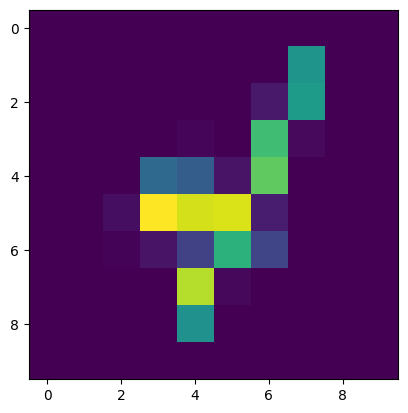

In [20]:
template_path = os.path.join(sweep_dir, "k_2_seqseq", "seed_0", "template.npy")
template_2d = np.load(template_path)
p1, p2 = template_2d.shape

plt.imshow(template_2d)

/tmp/ipykernel_128294/1914126371.py:113: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


Outliers from k_2_seqseq removed for plot
Outliers from k_3_seqseq removed for plot
Outliers from k_4_seqseq removed for plot
Outliers from k_5_seqseq removed for plot
Outliers from k_6_seqseq removed for plot
Outliers from k_7_seqseq removed for plot
Outliers from k_8_seqseq removed for plot


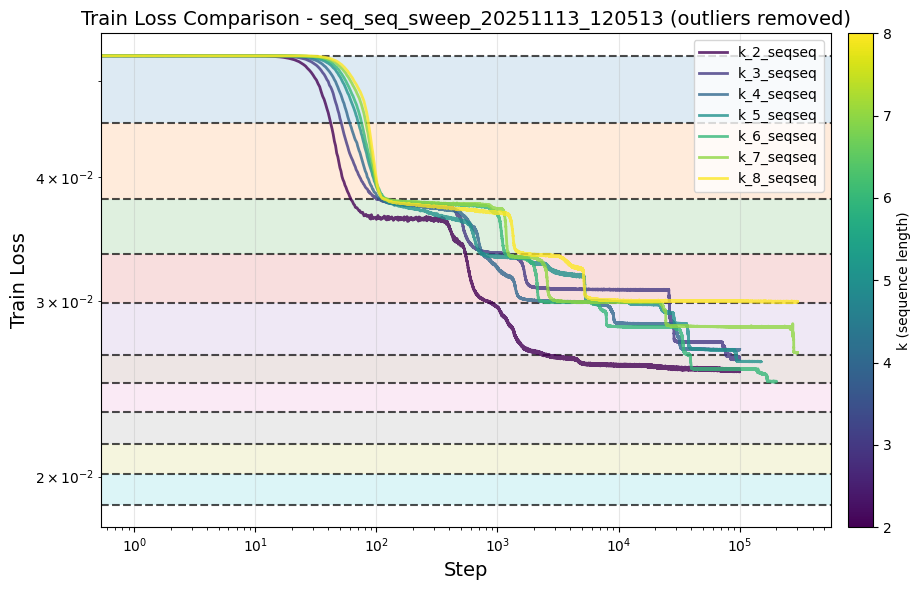

Theory plateau levels:
  Plateau 0: 5.298448e-02
  Plateau 1: 4.530677e-02
  Plateau 2: 3.806381e-02
  Plateau 3: 3.347446e-02
  Plateau 4: 2.991633e-02
  Plateau 5: 2.651234e-02
  Plateau 6: 2.485670e-02
  Plateau 7: 2.321230e-02
  Plateau 8: 2.157320e-02
  Plateau 9: 2.010709e-02
  Plateau 10: 1.874044e-02


In [5]:
# First, load the template from one of your experiments
# (assuming they all use the same template)
template_path = os.path.join(sweep_dir, "k_2_seqseq", "seed_0", "template.npy")
template_2d = np.load(template_path)
p1, p2 = template_2d.shape

# Plot with theory lines
fig, ax, theory_levels = plot_loss_comparison(
    sweep_dir,
    template_2d=template_2d,
    p1=p1,
    p2=p2,
    remove_outliers=True,
    num_theory_lines=10,  # Show first 10 theory lines
    log_scale=True,
    cmap="viridis",
)

# Print the theory levels (plateau values)
print("Theory plateau levels:")
for i, level in enumerate(theory_levels):
    print(f"  Plateau {i}: {level:.6e}")

### Time to reach plateau

In [6]:
def calculate_time_to_plateau(
    sweep_dir: str,
    template_2d: np.ndarray,
    p1: int,
    p2: int,
    target_plateau_idx: int = 1,
    loss_type: str = "train",
    seed: int = 0,
    tolerance: float = 1.1,
    experiments: Optional[List[str]] = None,
) -> Dict[str, int]:
    """
    Calculate the step at which each experiment's loss reaches a target plateau.

    Args:
        sweep_dir: Path to sweep directory
        template_2d: 2D template array for computing theory lines
        p1, p2: Dimensions of template
        target_plateau_idx: Index of target plateau (1 = first drop, 2 = second drop, etc.)
        loss_type: 'train' or 'val'
        seed: Seed number
        tolerance: Multiplier for plateau threshold (loss must be <= tolerance * plateau_level)
        experiments: List of experiment names (None = all experiments)

    Returns:
        Dictionary mapping experiment names to step numbers
    """
    from gagf.rnns.utils import get_power_2d_adele

    # Compute theory levels
    _, _, power = get_power_2d_adele(template_2d)
    power_flat = np.sort(power.flatten()[power.flatten() > 1e-20])[::-1]
    alpha_values = np.array([np.sum(power_flat[k:]) for k in range(len(power_flat))])
    coef = 1.0 / (p1 * p2)
    theory_levels = coef * alpha_values

    if target_plateau_idx >= len(theory_levels):
        raise ValueError(
            f"target_plateau_idx {target_plateau_idx} exceeds available plateaus ({len(theory_levels)})"
        )

    target_level = theory_levels[target_plateau_idx]
    threshold = tolerance * target_level

    if experiments is None:
        experiments = get_sweep_experiments(sweep_dir)

    times_to_plateau = {}

    for exp_name in experiments:
        losses = load_experiment_losses(sweep_dir, exp_name, seed)
        if loss_type in losses:
            loss_history = losses[loss_type]

            # Find first step where loss drops below threshold
            crossing_indices = np.where(loss_history <= threshold)[0]

            if len(crossing_indices) > 0:
                times_to_plateau[exp_name] = crossing_indices[0]
            else:
                times_to_plateau[exp_name] = None  # Never reached

    return times_to_plateau, theory_levels


def plot_time_to_plateau(
    sweep_dir: str,
    template_2d: np.ndarray,
    p1: int,
    p2: int,
    target_plateau_idx: int = 1,
    loss_type: str = "train",
    seed: int = 0,
    tolerance: float = 1.1,
    experiments: Optional[List[str]] = None,
    figsize: tuple = (10, 6),
    sort_by: str = "time",
):
    """
    Plot the time to reach a target plateau for different experiments.

    Args:
        sweep_dir: Path to sweep directory
        template_2d: 2D template array
        p1, p2: Template dimensions
        target_plateau_idx: Which plateau to measure (1 = first drop)
        loss_type: 'train' or 'val'
        seed: Seed number
        tolerance: Multiplier for plateau threshold
        experiments: List of experiment names (None = all)
        figsize: Figure size
        sort_by: 'time' (sort by time to plateau) or 'name' (alphabetical)
    """
    times, theory_levels = calculate_time_to_plateau(
        sweep_dir,
        template_2d,
        p1,
        p2,
        target_plateau_idx,
        loss_type,
        seed,
        tolerance,
        experiments,
    )

    # Filter out experiments that never reached the plateau
    reached = {k: v for k, v in times.items() if v is not None}
    not_reached = [k for k, v in times.items() if v is None]

    if not reached:
        print("No experiments reached the target plateau!")
        return

    # Sort experiments
    if sort_by == "time":
        sorted_items = sorted(reached.items(), key=lambda x: x[1])
    else:  # alphabetical
        sorted_items = sorted(reached.items(), key=lambda x: x[0])

    exp_names = [item[0] for item in sorted_items]
    steps = [item[1] for item in sorted_items]

    # Create bar plot
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(range(len(exp_names)), steps, alpha=0.7, edgecolor="black")

    # Color bars by value (gradient)
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(steps)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    ax.set_xticks(range(len(exp_names)))
    ax.set_xticklabels(exp_names, rotation=45, ha="right")
    ax.set_xlabel("Experiment", fontsize=12)
    ax.set_ylabel("Steps to Reach Plateau", fontsize=12)
    ax.set_title(
        f"Time to Reach Plateau {target_plateau_idx} (Level: {theory_levels[target_plateau_idx]:.2e})",
        fontsize=13,
    )
    ax.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for i, (bar, step) in enumerate(zip(bars, steps)):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(step):,}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()

    # Print summary
    print(
        f"\nTime to reach plateau {target_plateau_idx} (threshold: {theory_levels[target_plateau_idx]:.2e}):"
    )
    print("-" * 60)
    for name, step in sorted_items:
        print(f"  {name:30s}: {step:8,} steps")

    if not_reached:
        print(f"\nExperiments that did not reach plateau {target_plateau_idx}:")
        for name in not_reached:
            print(f"  - {name}")

    plt.show()

    return fig, ax, times, theory_levels

In [7]:
def plot_time_to_plateau(
    sweep_dir: str,
    template_2d: np.ndarray,
    p1: int,
    p2: int,
    target_plateau_idx: int = 1,
    loss_type: str = "train",
    seed: int = 0,
    tolerance: float = 1.1,
    experiments: Optional[List[str]] = None,
    figsize: tuple = (10, 6),
    sort_by: str = "time",
    color_by_k: bool = True,
    cmap: str = "viridis",
):
    """
    Plot the time to reach a target plateau for different experiments.

    Args:
        sweep_dir: Path to sweep directory
        template_2d: 2D template array
        p1, p2: Template dimensions
        target_plateau_idx: Which plateau to measure (1 = first drop)
        loss_type: 'train' or 'val'
        seed: Seed number
        tolerance: Multiplier for plateau threshold
        experiments: List of experiment names (None = all)
        figsize: Figure size
        sort_by: 'time' (sort by time to plateau) or 'name' (alphabetical)
        color_by_k: Whether to color bars by k value (default: True)
        cmap: Colormap name for k-based coloring (default: 'viridis')
    """
    times, theory_levels = calculate_time_to_plateau(
        sweep_dir,
        template_2d,
        p1,
        p2,
        target_plateau_idx,
        loss_type,
        seed,
        tolerance,
        experiments,
    )

    # Filter out experiments that never reached the plateau
    reached = {k: v for k, v in times.items() if v is not None}
    not_reached = [k for k, v in times.items() if v is None]

    if not reached:
        print("No experiments reached the target plateau!")
        return

    # Sort experiments
    if sort_by == "time":
        sorted_items = sorted(reached.items(), key=lambda x: x[1])
    else:  # alphabetical
        sorted_items = sorted(reached.items(), key=lambda x: x[0])

    exp_names = [item[0] for item in sorted_items]
    steps = [item[1] for item in sorted_items]

    # Extract k values and set up colormap
    k_values = []
    if color_by_k:
        import re

        for exp_name in exp_names:
            # Try to extract k value from experiment name (e.g., "k_2_seqseq" -> 2)
            match = re.search(r"k[_\s]*(\d+)", exp_name, re.IGNORECASE)
            if match:
                k_values.append(int(match.group(1)))
            else:
                k_values.append(None)

        # Check if we have valid k values
        valid_k_values = [k for k in k_values if k is not None]
        if valid_k_values:
            k_min = min(valid_k_values)
            k_max = max(valid_k_values)
            norm = plt.cm.colors.Normalize(vmin=k_min, vmax=k_max)
            colormap = plt.cm.get_cmap(cmap)
            scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
        else:
            color_by_k = False  # Fall back if no k values found

    # Create bar plot
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(range(len(exp_names)), steps, alpha=0.7, edgecolor="black")

    # Color bars
    if color_by_k and valid_k_values:
        for bar, k_val in zip(bars, k_values):
            if k_val is not None:
                bar.set_color(scalar_map.to_rgba(k_val))
            else:
                bar.set_color("gray")  # Fallback color
    else:
        # Color bars by position (gradient from blue to yellow)
        colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(steps)))
        for bar, color in zip(bars, colors):
            bar.set_color(color)

    ax.set_xticks(range(len(exp_names)))
    ax.set_xticklabels(exp_names, rotation=45, ha="right")
    ax.set_xlabel("Experiment", fontsize=12)
    ax.set_ylabel("Steps to Reach Plateau", fontsize=12)
    ax.set_title(
        f"Time to Reach Plateau {target_plateau_idx} (Level: {theory_levels[target_plateau_idx]:.2e})",
        fontsize=13,
    )
    ax.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for i, (bar, step) in enumerate(zip(bars, steps)):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{int(step):,}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # Add colorbar if coloring by k
    if color_by_k and valid_k_values:
        cbar = plt.colorbar(scalar_map, ax=ax, label="k (sequence length)", pad=0.02)
        cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()

    # Print summary
    print(
        f"\nTime to reach plateau {target_plateau_idx} (threshold: {theory_levels[target_plateau_idx]:.2e}):"
    )
    print("-" * 60)
    for name, step in sorted_items:
        print(f"  {name:30s}: {step:8,} steps")

    if not_reached:
        print(f"\nExperiments that did not reach plateau {target_plateau_idx}:")
        for name in not_reached:
            print(f"  - {name}")

    plt.show()

    return fig, ax, times, theory_levels

In [8]:
# Load template
template_path = os.path.join(sweep_dir, "k_2_seqseq", "seed_0", "template.npy")
template_2d = np.load(template_path)
p1, p2 = template_2d.shape

# get the times without plotting
times_dict, theory_levels = calculate_time_to_plateau(
    sweep_dir, template_2d, p1, p2, target_plateau_idx=1
)


Time to reach plateau 1 (threshold: 4.53e-02):
------------------------------------------------------------
  k_2_seqseq                    :       33 steps
  k_3_seqseq                    :       41 steps
  k_4_seqseq                    :       47 steps
  k_5_seqseq                    :       53 steps
  k_6_seqseq                    :       57 steps
  k_7_seqseq                    :       63 steps
  k_8_seqseq                    :       67 steps


/tmp/ipykernel_128294/2488080501.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


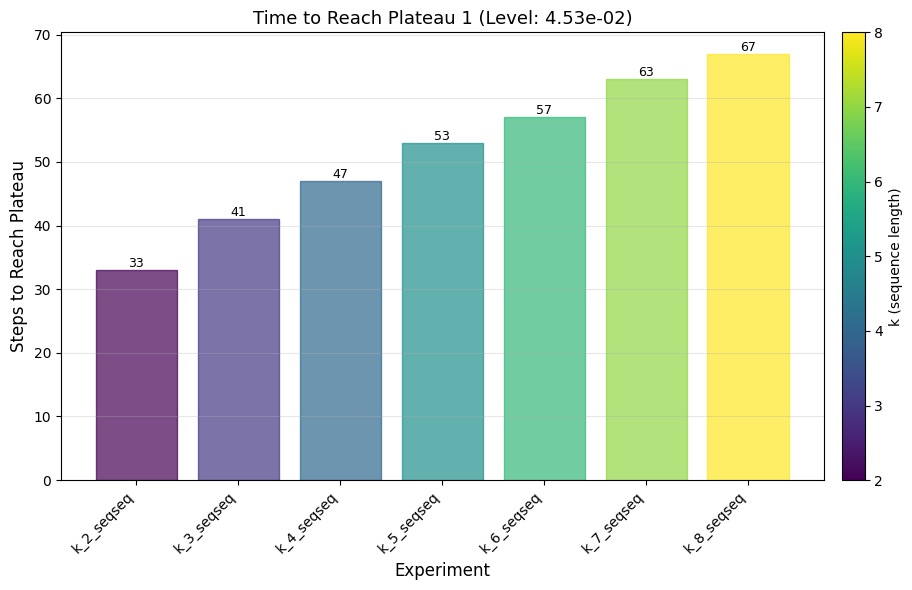

/tmp/ipykernel_128294/2488080501.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)



Time to reach plateau 2 (threshold: 3.81e-02):
------------------------------------------------------------
  k_2_seqseq                    :       53 steps
  k_3_seqseq                    :       74 steps
  k_4_seqseq                    :       85 steps
  k_5_seqseq                    :       95 steps
  k_6_seqseq                    :       98 steps
  k_7_seqseq                    :       98 steps
  k_8_seqseq                    :      100 steps


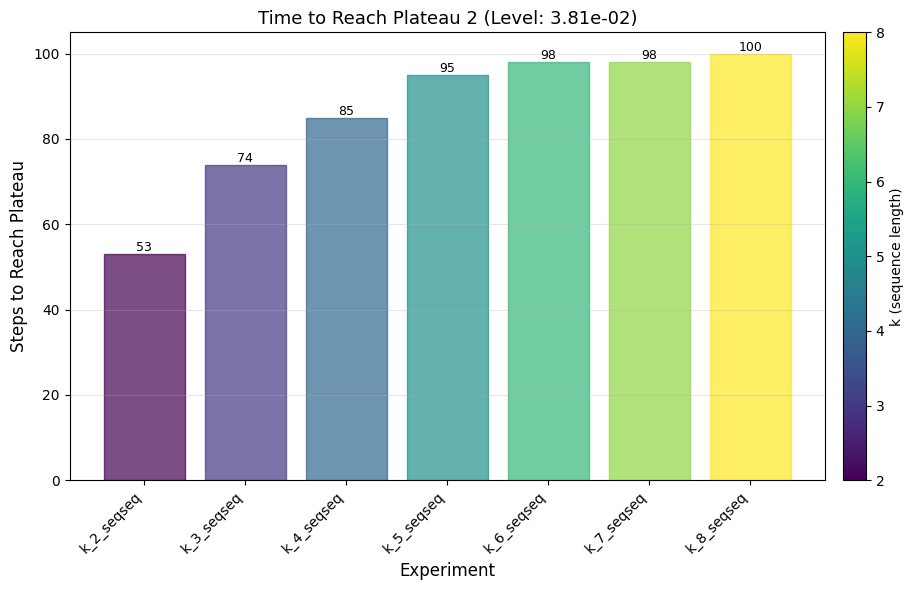

/tmp/ipykernel_128294/2488080501.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)



Time to reach plateau 3 (threshold: 3.35e-02):
------------------------------------------------------------
  k_2_seqseq                    :      416 steps
  k_3_seqseq                    :      537 steps
  k_4_seqseq                    :      674 steps
  k_5_seqseq                    :      628 steps
  k_6_seqseq                    :    1,078 steps
  k_7_seqseq                    :    1,180 steps
  k_8_seqseq                    :    1,338 steps


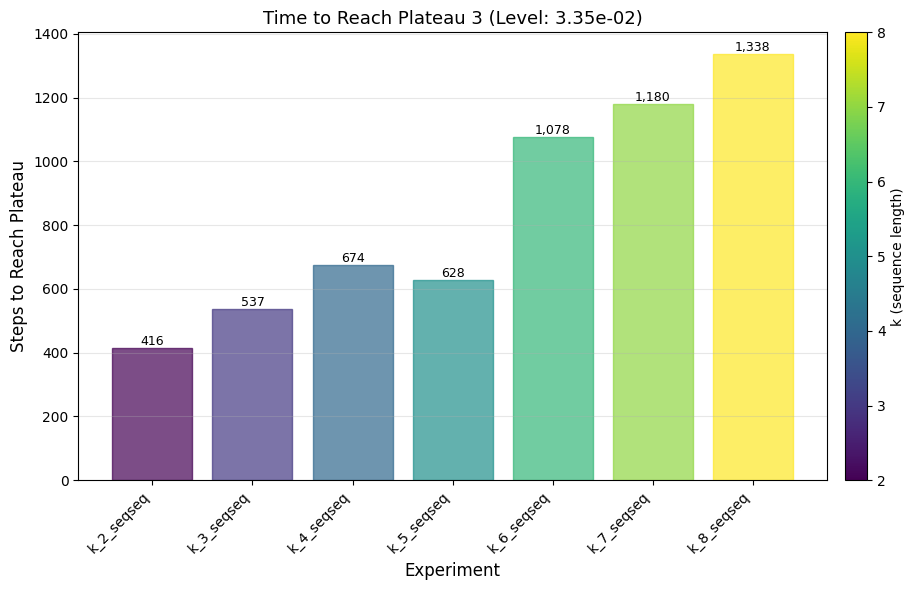

/tmp/ipykernel_128294/2488080501.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)



Time to reach plateau 4 (threshold: 2.99e-02):
------------------------------------------------------------
  k_2_seqseq                    :      607 steps
  k_3_seqseq                    :    1,735 steps
  k_4_seqseq                    :    1,365 steps
  k_5_seqseq                    :    5,250 steps
  k_6_seqseq                    :    2,116 steps
  k_7_seqseq                    :    2,578 steps
  k_8_seqseq                    :    5,183 steps


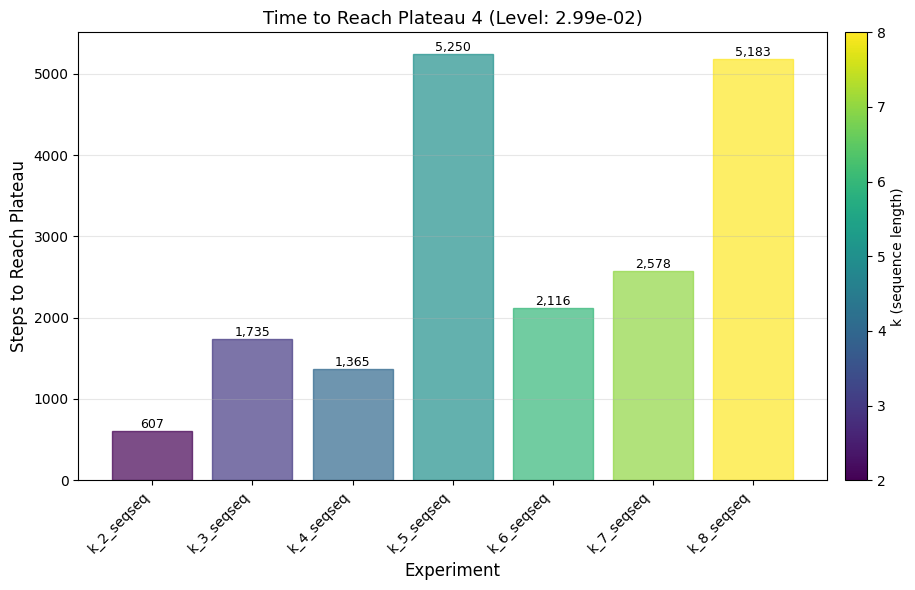

In [12]:
# Plot time to first drop (plateau index 1)
fig, ax, times, levels = plot_time_to_plateau(
    sweep_dir,
    template_2d,
    p1,
    p2,
    target_plateau_idx=1,  # First drop
    tolerance=1.1,  # Loss must be <= 1.1 * theory_level
    sort_by="name",
)

# Plot time to second drop (plateau index 2)
plot_time_to_plateau(
    sweep_dir,
    template_2d,
    p1,
    p2,
    target_plateau_idx=2,
    tolerance=1.05,  # Second drop
    cmap="viridis",
    sort_by="name",
)

# Plot time to third drop (plateau index 3)
plot_time_to_plateau(
    sweep_dir,
    template_2d,
    p1,
    p2,
    target_plateau_idx=3,
    tolerance=1.05,  # Second drop
    cmap="viridis",
    sort_by="name",
)

# Plot time to fourth drop (plateau index 4)
plot_time_to_plateau(
    sweep_dir,
    template_2d,
    p1,
    p2,
    target_plateau_idx=4,
    tolerance=1.05,  # Second drop
    cmap="viridis",
    sort_by="name",
);

## Sequence-to-one sweep across different values of k (sequence length)

- 1st sweep dir: "/home/facosta/group-agf/sweeps/optim_sweep_20251113_001549" (k=4, 5)
- 2nd sweep dir: "/home/facosta/group-agf/sweeps/optim_sweep_20251113_145528" (k=2, 3)

In [25]:
def load_losses_from_multiple_sweeps(
    sweep_experiments: Dict[str, List[str]], loss_type: str = "train", seed: int = 0
) -> Dict[str, Dict[str, np.ndarray]]:
    """
    Load loss histories from experiments across multiple sweeps.

    Args:
        sweep_experiments: Dictionary mapping sweep_dir -> list of experiment names
                          e.g., {sweep_dir_1: ["exp1", "exp2"], sweep_dir_2: ["exp3", "exp4"]}
        loss_type: 'train' or 'val'
        seed: Seed number

    Returns:
        Dictionary mapping experiment names to their loss dictionaries
        Note: Experiment names must be unique across sweeps
    """
    all_losses = {}

    for sweep_dir, exp_names in sweep_experiments.items():
        for exp_name in exp_names:
            losses = load_experiment_losses(sweep_dir, exp_name, seed)
            if loss_type in losses:
                # Store with experiment name as key
                all_losses[exp_name] = losses
            else:
                print(
                    f"Warning: No {loss_type} loss found for {exp_name} in {sweep_dir}"
                )

    return all_losses


def create_color_mapping_from_multiple_sweeps(
    sweep_experiments: Dict[str, List[str]],
    parameter_path: str,
    cmap: str = "viridis",
    seed: int = 0,
    log_scale: bool = False,
) -> tuple:
    """
    Create color mapping for experiments across multiple sweeps.

    Args:
        sweep_experiments: Dictionary mapping sweep_dir -> list of experiment names
        parameter_path: Dot-separated path to parameter (e.g., 'data.batch_size')
        cmap: Colormap name
        seed: Seed number
        log_scale: Whether to use logarithmic scale for color mapping

    Returns:
        Tuple of (color_mapping dict, scalar_map, param_values dict)
    """
    param_values = {}

    # Extract parameters from all experiments across all sweeps
    for sweep_dir, exp_names in sweep_experiments.items():
        for exp_name in exp_names:
            value = extract_config_parameter(sweep_dir, exp_name, parameter_path, seed)
            if value is not None:
                param_values[exp_name] = value

    if not param_values:
        print(f"Warning: Could not extract '{parameter_path}' from any experiments")
        return {}, None, {}

    # Create color mapping
    values = list(param_values.values())
    v_min = min(values)
    v_max = max(values)

    # Use log or linear normalization
    if log_scale:
        if v_min <= 0:
            print(
                f"Warning: log_scale requested but found non-positive values (min={v_min}). Using linear scale."
            )
            norm = plt.cm.colors.Normalize(vmin=v_min, vmax=v_max)
        else:
            norm = plt.cm.colors.LogNorm(vmin=v_min, vmax=v_max)
    else:
        norm = plt.cm.colors.Normalize(vmin=v_min, vmax=v_max)

    colormap = plt.cm.get_cmap(cmap)

    color_mapping = {}
    for exp_name, value in param_values.items():
        color_mapping[exp_name] = colormap(norm(value))

    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=colormap)

    return color_mapping, scalar_map, param_values


def plot_loss_comparison_multi_sweep(
    sweep_experiments: Dict[str, List[str]],
    loss_type: str = "train",
    log_scale: bool = True,
    figsize: tuple = (10, 6),
    seed: int = 0,
    remove_outliers: bool = False,
    outlier_window: int = 10,
    outlier_threshold: float = 3.0,
    template_2d: Optional[np.ndarray] = None,
    p1: Optional[int] = None,
    p2: Optional[int] = None,
    show_theory_bands: bool = True,
    num_theory_lines: Optional[int] = None,
    color_mapping: Optional[Dict[str, tuple]] = None,
    colorbar_label: Optional[str] = None,
    scalar_map: Optional[plt.cm.ScalarMappable] = None,
):
    """
    Plot and compare loss curves from experiments across multiple sweeps.

    Args:
        sweep_experiments: Dictionary mapping sweep_dir -> list of experiment names
                          e.g., {sweep_dir_1: ["exp1", "exp2"], sweep_dir_2: ["exp3"]}
        loss_type: 'train' or 'val'
        log_scale: Whether to use log scale for both axes
        figsize: Figure size tuple
        seed: Seed number
        remove_outliers: Whether to remove outliers
        outlier_window: Window size for outlier detection
        outlier_threshold: Threshold for outlier detection
        template_2d: Optional 2D template array for computing theory lines
        p1, p2: Template dimensions
        show_theory_bands: Whether to show colored bands between theory lines
        num_theory_lines: Number of theory lines to show
        color_mapping: Dictionary mapping experiment names to RGBA colors
        colorbar_label: Label for colorbar
        scalar_map: ScalarMappable for colorbar
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Compute theory lines if template is provided
    theory_levels = None
    if template_2d is not None:
        if p1 is None or p2 is None:
            raise ValueError("p1 and p2 must be provided if template_2d is given")

        from gagf.rnns.utils import get_power_2d_adele

        _, _, power = get_power_2d_adele(template_2d)
        power_flat = np.sort(power.flatten()[power.flatten() > 1e-20])[::-1]

        alpha_values = np.array(
            [np.sum(power_flat[k:]) for k in range(len(power_flat))]
        )
        coef = 1.0 / (p1 * p2)
        theory_levels = coef * alpha_values

        if num_theory_lines is not None:
            theory_levels = theory_levels[: num_theory_lines + 1]

        n_bands = len(theory_levels) - 1
        colors = plt.cm.tab10(np.linspace(0, 1, max(n_bands, 1)))

        if show_theory_bands and n_bands > 0:
            for i in range(n_bands):
                y_top = theory_levels[i]
                y_bot = theory_levels[i + 1]
                ax.axhspan(
                    y_bot,
                    y_top,
                    facecolor=colors[i % len(colors)],
                    alpha=0.15,
                    zorder=-3,
                )

        for y in theory_levels:
            ax.axhline(
                y=y,
                color="black",
                linestyle="--",
                linewidth=1.5,
                alpha=0.7,
                zorder=-2,
                label="_nolegend_",
            )

    # Plot loss curves from all sweeps
    for sweep_dir, exp_names in sweep_experiments.items():
        for exp_name in exp_names:
            losses = load_experiment_losses(sweep_dir, exp_name, seed)
            if loss_type in losses:
                loss_history = losses[loss_type]

                if remove_outliers:
                    loss_history, outliers_found = remove_outliers_local(
                        loss_history, window=outlier_window, threshold=outlier_threshold
                    )
                    if outliers_found:
                        print(f"Outliers from {exp_name} removed for plot")

                # Determine color
                if color_mapping and exp_name in color_mapping:
                    color = color_mapping[exp_name]
                else:
                    color = None

                ax.plot(
                    loss_history, label=exp_name, alpha=0.8, linewidth=2, color=color
                )

    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel(f"{loss_type.capitalize()} Loss", fontsize=14)
    ax.set_title(
        f"{loss_type.capitalize()} Loss Comparison (Multiple Sweeps)", fontsize=14
    )
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    if log_scale:
        ax.set_xscale("log")
        ax.set_yscale("log")

    if color_mapping and scalar_map is not None:
        label = colorbar_label if colorbar_label else "Parameter Value"
        cbar = plt.colorbar(scalar_map, ax=ax, label=label, pad=0.02)
        cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

    return fig, ax, theory_levels

/tmp/ipykernel_128294/1234058534.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)
/tmp/ipykernel_128294/1234058534.py:204: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/facosta/.cache/pypoetry/virtualenvs/gagf-PDhBFja6-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


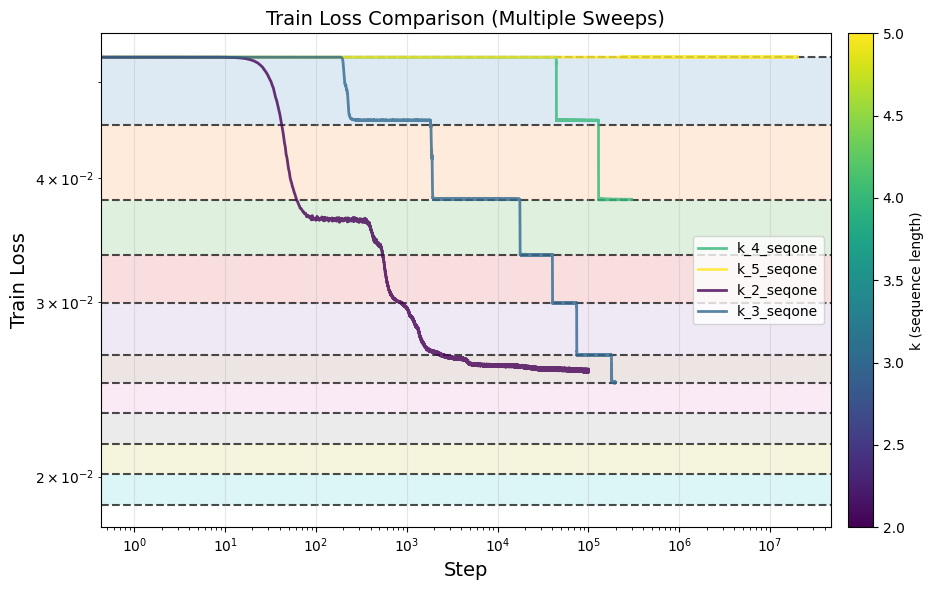

Extracted k values: {'k_4_seqone': 4, 'k_5_seqone': 5, 'k_2_seqone': 2, 'k_3_seqone': 3}


In [27]:
# Define which experiments from which sweeps
sweep_experiments = {
    "/home/facosta/group-agf/sweeps/optim_sweep_20251113_001549": [
        "k_4_seqone",
        "k_5_seqone",
    ],
    "/home/facosta/group-agf/sweeps/optim_sweep_20251113_145528": [
        "k_2_seqone",
        "k_3_seqone",
    ],
}

# Load template (assuming same template across all)
template_path = os.path.join(
    list(sweep_experiments.keys())[0],  # First sweep
    list(sweep_experiments.values())[0][0],  # First experiment
    "seed_0",
    "template.npy",
)
template_2d = np.load(template_path)
p1, p2 = template_2d.shape

# Create color mapping based on parameter across all sweeps
color_map, scalar_map, k_values = create_color_mapping_from_multiple_sweeps(
    sweep_experiments,
    "data.k",  # or 'data.batch_size', 'training.learning_rate', etc.
    cmap="viridis",
    log_scale=False,
)

# Plot
plot_loss_comparison_multi_sweep(
    sweep_experiments,
    template_2d=template_2d,
    p1=p1,
    p2=p2,
    color_mapping=color_map,
    colorbar_label="k (sequence length)",
    scalar_map=scalar_map,
    num_theory_lines=10,
    remove_outliers=False,
    log_scale=True,
)

# Print extracted values to verify
print("Extracted k values:", k_values)

In [28]:
def calculate_time_to_plateau_multi_sweep(
    sweep_experiments: Dict[str, List[str]],
    template_2d: np.ndarray,
    p1: int,
    p2: int,
    target_plateau_idx: int = 1,
    loss_type: str = "train",
    seed: int = 0,
    tolerance: float = 1.1,
) -> tuple:
    """
    Calculate time to plateau for experiments across multiple sweeps.

    Args:
        sweep_experiments: Dictionary mapping sweep_dir -> list of experiment names
        template_2d: 2D template array
        p1, p2: Template dimensions
        target_plateau_idx: Which plateau to measure (1 = first drop)
        loss_type: 'train' or 'val'
        seed: Seed number
        tolerance: Multiplier for plateau threshold

    Returns:
        Tuple of (times_to_plateau dict, theory_levels array)
    """
    from gagf.rnns.utils import get_power_2d_adele

    # Compute theory levels
    _, _, power = get_power_2d_adele(template_2d)
    power_flat = np.sort(power.flatten()[power.flatten() > 1e-20])[::-1]
    alpha_values = np.array([np.sum(power_flat[k:]) for k in range(len(power_flat))])
    coef = 1.0 / (p1 * p2)
    theory_levels = coef * alpha_values

    if target_plateau_idx >= len(theory_levels):
        raise ValueError(
            f"target_plateau_idx {target_plateau_idx} exceeds available plateaus ({len(theory_levels)})"
        )

    target_level = theory_levels[target_plateau_idx]
    threshold = tolerance * target_level

    times_to_plateau = {}

    # Process all experiments across all sweeps
    for sweep_dir, exp_names in sweep_experiments.items():
        for exp_name in exp_names:
            losses = load_experiment_losses(sweep_dir, exp_name, seed)
            if loss_type in losses:
                loss_history = losses[loss_type]

                # Find first step where loss drops below threshold
                crossing_indices = np.where(loss_history <= threshold)[0]

                if len(crossing_indices) > 0:
                    times_to_plateau[exp_name] = crossing_indices[0]
                else:
                    times_to_plateau[exp_name] = None  # Never reached

    return times_to_plateau, theory_levels


def plot_time_to_plateau_multi_sweep(
    sweep_experiments: Dict[str, List[str]],
    template_2d: np.ndarray,
    p1: int,
    p2: int,
    target_plateau_idx: int = 1,
    loss_type: str = "train",
    seed: int = 0,
    tolerance: float = 1.1,
    figsize: tuple = (10, 6),
    sort_by: str = "time",
    color_mapping: Optional[Dict[str, tuple]] = None,
    colorbar_label: Optional[str] = None,
    scalar_map: Optional[plt.cm.ScalarMappable] = None,
    show_not_reached: bool = True,
):
    """
    Plot time to reach a target plateau for experiments across multiple sweeps.

    Args:
        sweep_experiments: Dictionary mapping sweep_dir -> list of experiment names
        template_2d: 2D template array
        p1, p2: Template dimensions
        target_plateau_idx: Which plateau to measure (1 = first drop)
        loss_type: 'train' or 'val'
        seed: Seed number
        tolerance: Multiplier for plateau threshold
        figsize: Figure size
        sort_by: 'time' (sort by time to plateau) or 'name' (alphabetical)
        color_mapping: Dictionary mapping experiment names to RGBA colors
        colorbar_label: Label for colorbar
        scalar_map: ScalarMappable for colorbar
        show_not_reached: Whether to show experiments that didn't reach plateau
    """
    times, theory_levels = calculate_time_to_plateau_multi_sweep(
        sweep_experiments,
        template_2d,
        p1,
        p2,
        target_plateau_idx,
        loss_type,
        seed,
        tolerance,
    )

    # Separate reached vs not reached
    reached = {k: v for k, v in times.items() if v is not None}
    not_reached = {k: v for k, v in times.items() if v is None}

    if not reached and not not_reached:
        print("No experiments found!")
        return

    # Sort experiments that reached the plateau
    if reached:
        if sort_by == "time":
            sorted_reached = sorted(reached.items(), key=lambda x: x[1])
        else:  # alphabetical
            sorted_reached = sorted(reached.items(), key=lambda x: x[0])
    else:
        sorted_reached = []

    # Add not-reached experiments at the end if requested
    if show_not_reached and not_reached:
        not_reached_sorted = sorted(not_reached.keys())
        exp_names = [item[0] for item in sorted_reached] + not_reached_sorted
        # Use a very large value for visualization (e.g., max reached time * 1.5)
        max_reached_time = max([v for v in reached.values()]) if reached else 10000
        placeholder_time = max_reached_time * 1.3
        steps = [item[1] for item in sorted_reached] + [placeholder_time] * len(
            not_reached_sorted
        )
        reached_mask = [True] * len(sorted_reached) + [False] * len(not_reached_sorted)
    else:
        exp_names = [item[0] for item in sorted_reached]
        steps = [item[1] for item in sorted_reached]
        reached_mask = [True] * len(sorted_reached)

    if not exp_names:
        print("No experiments to plot!")
        return

    # Create bar plot
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.bar(range(len(exp_names)), steps, alpha=0.7, edgecolor="black")

    # Color bars
    for i, (bar, exp_name, did_reach) in enumerate(zip(bars, exp_names, reached_mask)):
        if not did_reach:
            # Gray out experiments that didn't reach plateau
            bar.set_color("lightgray")
            bar.set_alpha(0.4)
            bar.set_hatch("///")
        elif color_mapping and exp_name in color_mapping:
            bar.set_color(color_mapping[exp_name])
        else:
            # Default gradient coloring
            colors = plt.cm.viridis(
                np.linspace(0.2, 0.9, len([m for m in reached_mask if m]))
            )
            bar.set_color(colors[i] if did_reach else "lightgray")

    ax.set_xticks(range(len(exp_names)))
    ax.set_xticklabels(exp_names, rotation=45, ha="right")
    ax.set_xlabel("Experiment", fontsize=12)
    ax.set_ylabel("Steps to Reach Plateau", fontsize=12)
    ax.set_title(
        f"Time to Reach Plateau {target_plateau_idx} (Level: {theory_levels[target_plateau_idx]:.2e})",
        fontsize=13,
    )
    ax.grid(True, alpha=0.3, axis="y")

    # Add value labels on bars
    for i, (bar, step, did_reach, exp_name) in enumerate(
        zip(bars, steps, reached_mask, exp_names)
    ):
        height = bar.get_height()
        if did_reach:
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{int(step):,}",
                ha="center",
                va="bottom",
                fontsize=9,
            )
        else:
            # Add "Did not reach" annotation
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height / 2,
                "Did not\nreach",
                ha="center",
                va="center",
                fontsize=8,
                style="italic",
                color="darkgray",
                weight="bold",
            )

    # Add colorbar if color mapping provided (only for experiments that reached)
    if color_mapping and scalar_map is not None and reached:
        label = colorbar_label if colorbar_label else "Parameter Value"
        cbar = plt.colorbar(scalar_map, ax=ax, label=label, pad=0.02)
        cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()

    # Print summary
    print(
        f"\nTime to reach plateau {target_plateau_idx} (threshold: {theory_levels[target_plateau_idx]:.2e}):"
    )
    print("-" * 60)
    if reached:
        for name, step in sorted_reached:
            print(f"  {name:30s}: {step:8,} steps")

    if not_reached:
        print(f"\nExperiments that did not reach plateau {target_plateau_idx}:")
        for name in not_reached_sorted:
            print(f"  - {name}")

    plt.show()

    return fig, ax, times, theory_levels

/tmp/ipykernel_128294/1234058534.py:81: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)



Time to reach plateau 1 (threshold: 4.53e-02):
------------------------------------------------------------
  k_2_seqone                    :       33 steps
  k_3_seqone                    :      210 steps
  k_4_seqone                    :   44,338 steps

Experiments that did not reach plateau 1:
  - k_5_seqone


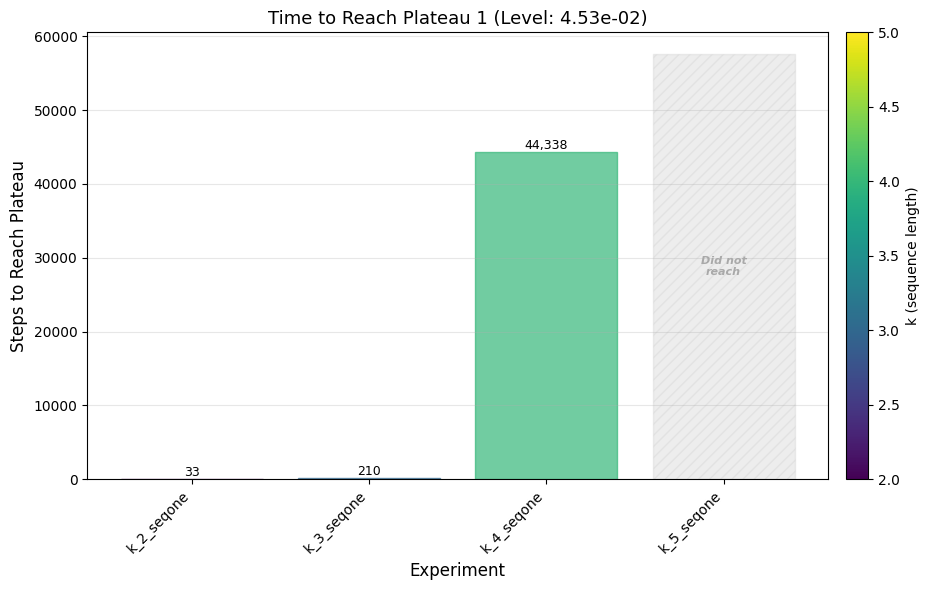


Time to reach plateau 1 (threshold: 4.53e-02):
------------------------------------------------------------
  k_2_seqone                    :       33 steps
  k_3_seqone                    :      210 steps
  k_4_seqone                    :   44,338 steps

Experiments that did not reach plateau 1:
  - k_5_seqone


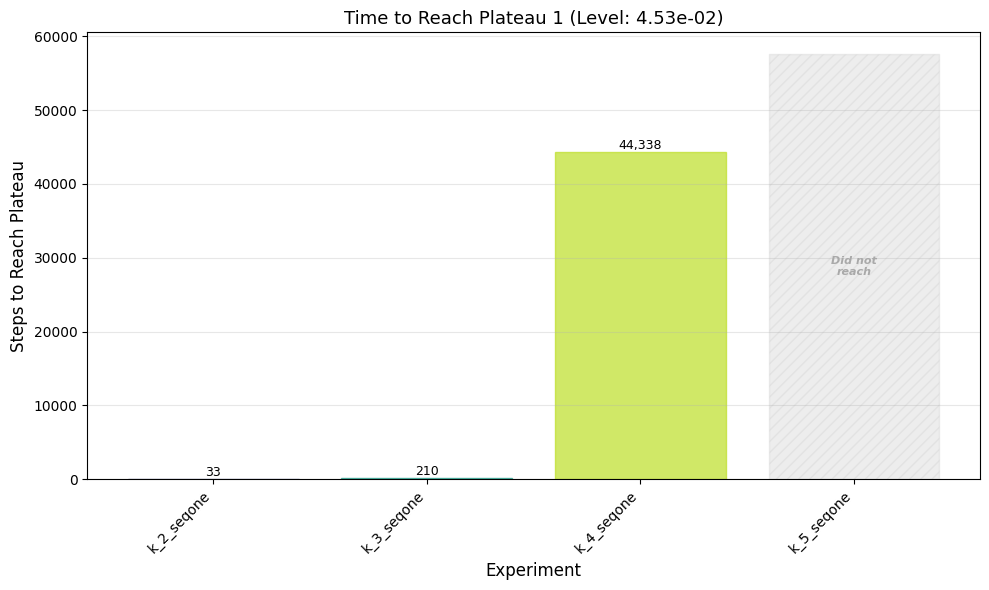

In [ ]:
# Define your experiments across multiple sweeps
sweep_experiments = {
    "/home/facosta/group-agf/sweeps/optim_sweep_20251113_001549": [
        "k_4_seqone",
        "k_5_seqone",
    ],
    "/home/facosta/group-agf/sweeps/optim_sweep_20251113_145528": [
        "k_2_seqone",
        "k_3_seqone",
    ],
}

# Load template
template_path = os.path.join(
    "/home/facosta/group-agf/sweeps/optim_sweep_20251113_001549",
    "k_4_seqone",
    "seed_0",
    "template.npy",
)
template_2d = np.load(template_path)
p1, p2 = template_2d.shape

# Create color mapping by k value
color_map, scalar_map, k_values = create_color_mapping_from_multiple_sweeps(
    sweep_experiments, "data.k", cmap="viridis", log_scale=False
)

# Plot time to first plateau
fig, ax, times, levels = plot_time_to_plateau_multi_sweep(
    sweep_experiments,
    template_2d,
    p1,
    p2,
    target_plateau_idx=1,  # First drop
    tolerance=1.1,
    color_mapping=color_map,
    colorbar_label="k (sequence length)",
    scalar_map=scalar_map,
    sort_by="name",  # or 'time'
    show_not_reached=True,  # Show experiments that didn't reach plateau
)

## Batch size sweep (seq-to-one, k=3)

In [18]:
import yaml


def extract_config_parameter(
    sweep_dir: str, experiment_name: str, parameter_path: str, seed: int = 0
) -> any:
    """
    Extract a parameter value from an experiment's config file.

    Args:
        sweep_dir: Path to sweep directory
        experiment_name: Name of experiment
        parameter_path: Dot-separated path to parameter (e.g., 'data.batch_size', 'training.learning_rate')
        seed: Seed number (for getting from seed_X/config.yaml)

    Returns:
        Parameter value or None if not found
    """
    # Try configs directory first
    config_path = Path(sweep_dir) / "configs" / f"{experiment_name}_config.yaml"

    # If not there, try seed_X directory
    if not config_path.exists():
        config_path = Path(sweep_dir) / experiment_name / f"seed_{seed}" / "config.yaml"

    if not config_path.exists():
        return None

    try:
        with open(config_path, "r") as f:
            config = yaml.safe_load(f)

        # Navigate through nested structure using dot notation
        value = config
        for key in parameter_path.split("."):
            value = value[key]

        return value
    except (KeyError, TypeError):
        return None


def create_color_mapping(
    sweep_dir: str,
    parameter_path: str,
    experiments: Optional[List[str]] = None,
    cmap: str = "viridis",
    seed: int = 0,
    log_scale: bool = False,
) -> tuple:
    """
    Create a color mapping for experiments based on a config parameter.

    Args:
        sweep_dir: Path to sweep directory
        parameter_path: Dot-separated path to parameter (e.g., 'data.batch_size')
        experiments: List of experiment names (None = all)
        cmap: Colormap name
        seed: Seed number
        log_scale: Whether to use logarithmic scale for color mapping

    Returns:
        Tuple of (color_mapping dict, scalar_map, param_values dict)
    """
    if experiments is None:
        experiments = get_sweep_experiments(sweep_dir)

    # Extract parameter values for all experiments
    param_values = {}
    for exp_name in experiments:
        value = extract_config_parameter(sweep_dir, exp_name, parameter_path, seed)
        if value is not None:
            param_values[exp_name] = value

    if not param_values:
        print(f"Warning: Could not extract '{parameter_path}' from any experiments")
        return {}, None, {}

    # Create color mapping
    values = list(param_values.values())
    v_min = min(values)
    v_max = max(values)

    # Use log or linear normalization
    if log_scale:
        if v_min <= 0:
            print(
                f"Warning: log_scale requested but found non-positive values (min={v_min}). Using linear scale."
            )
            norm = plt.cm.colors.Normalize(vmin=v_min, vmax=v_max)
        else:
            norm = plt.cm.colors.LogNorm(vmin=v_min, vmax=v_max)
    else:
        norm = plt.cm.colors.Normalize(vmin=v_min, vmax=v_max)

    colormap = plt.cm.get_cmap(cmap)

    color_mapping = {}
    for exp_name, value in param_values.items():
        color_mapping[exp_name] = colormap(norm(value))

    # Also return the scalar mappable for colorbar
    scalar_map = plt.cm.ScalarMappable(norm=norm, cmap=colormap)

    return color_mapping, scalar_map, param_values

In [14]:
def plot_loss_comparison(
    sweep_dir: str,
    experiments: Optional[List[str]] = None,
    loss_type: str = "train",
    log_scale: bool = True,
    figsize: tuple = (10, 6),
    seed: int = 0,
    remove_outliers: bool = False,
    outlier_window: int = 10,
    outlier_threshold: float = 3.0,
    template_2d: Optional[np.ndarray] = None,
    p1: Optional[int] = None,
    p2: Optional[int] = None,
    show_theory_bands: bool = True,
    num_theory_lines: Optional[int] = None,
    color_mapping: Optional[Dict[str, tuple]] = None,
    colorbar_label: Optional[str] = None,
    scalar_map: Optional[plt.cm.ScalarMappable] = None,
):
    """
    Plot and compare loss curves from multiple experiments.

    Args:
        sweep_dir: Path to sweep directory
        experiments: List of experiment names to plot (None = all experiments)
        loss_type: 'train' or 'val'
        log_scale: Whether to use log scale for both axes
        figsize: Figure size tuple
        seed: Seed number (default: 0)
        remove_outliers: Whether to remove outliers using local outlier replacement
        outlier_window: Window size for outlier detection (default: 10)
        outlier_threshold: Threshold in standard deviations for outlier detection (default: 3.0)
        template_2d: Optional 2D template array for computing theory lines
        p1: First dimension of template (required if template_2d is provided)
        p2: Second dimension of template (required if template_2d is provided)
        show_theory_bands: Whether to show colored bands between theory lines (default: True)
        num_theory_lines: Number of theory lines to show (default: None = show all)
        color_mapping: Dictionary mapping experiment names to RGBA colors
        colorbar_label: Label for colorbar (if color_mapping provided)
        scalar_map: ScalarMappable for colorbar (if color_mapping provided)
    """
    if experiments is None:
        experiments = get_sweep_experiments(sweep_dir)

    fig, ax = plt.subplots(figsize=figsize)

    # Compute theory lines if template is provided
    theory_levels = None
    if template_2d is not None:
        if p1 is None or p2 is None:
            raise ValueError("p1 and p2 must be provided if template_2d is given")

        # Import the helper function (assuming it's in utils.py)
        from gagf.rnns.utils import get_power_2d_adele

        # Compute power spectrum of template
        _, _, power = get_power_2d_adele(template_2d)
        power_flat = np.sort(power.flatten()[power.flatten() > 1e-20])[::-1]

        # Theory levels (cumulative tail sums)
        alpha_values = np.array(
            [np.sum(power_flat[k:]) for k in range(len(power_flat))]
        )
        coef = 1.0 / (p1 * p2)
        theory_levels = coef * alpha_values  # strictly decreasing

        # Limit number of lines if specified
        if num_theory_lines is not None:
            theory_levels = theory_levels[: num_theory_lines + 1]

        # Generate colors for bands
        n_bands = len(theory_levels) - 1
        colors = plt.cm.tab10(np.linspace(0, 1, max(n_bands, 1)))

        # Draw colored bands between theory lines
        if show_theory_bands and n_bands > 0:
            for i in range(n_bands):
                y_top = theory_levels[i]
                y_bot = theory_levels[i + 1]
                ax.axhspan(
                    y_bot,
                    y_top,
                    facecolor=colors[i % len(colors)],
                    alpha=0.15,
                    zorder=-3,
                )

        # Draw the black theory lines
        for y in theory_levels:
            ax.axhline(
                y=y,
                color="black",
                linestyle="--",
                linewidth=1.5,
                alpha=0.7,
                zorder=-2,
                label="_nolegend_",
            )

    # Plot loss curves
    for exp_name in experiments:
        losses = load_experiment_losses(sweep_dir, exp_name, seed)
        if loss_type in losses:
            loss_history = losses[loss_type]

            # Apply outlier removal if requested
            if remove_outliers:
                loss_history, outliers_found = remove_outliers_local(
                    loss_history, window=outlier_window, threshold=outlier_threshold
                )
                if outliers_found:
                    print(f"Outliers from {exp_name} removed for plot")

            # Determine color
            if color_mapping and exp_name in color_mapping:
                color = color_mapping[exp_name]
            else:
                color = None  # Use default color cycle

            ax.plot(loss_history, label=exp_name, alpha=0.8, linewidth=2, color=color)

    ax.set_xlabel("Step", fontsize=14)
    ax.set_ylabel(f"{loss_type.capitalize()} Loss", fontsize=14)
    title = f"{loss_type.capitalize()} Loss Comparison - {Path(sweep_dir).name}"
    if remove_outliers:
        title += " (outliers removed)"
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    if log_scale:
        ax.set_xscale("log")
        ax.set_yscale("log")

    # Add colorbar if color mapping provided
    if color_mapping and scalar_map is not None:
        label = colorbar_label if colorbar_label else "Parameter Value"
        cbar = plt.colorbar(scalar_map, ax=ax, label=label, pad=0.02)
        cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

    return fig, ax, theory_levels

In [15]:
# Set up your sweep directory
batch_sweep_dir = "/home/facosta/group-agf/sweeps/batch_sweep_20251113_171834"

# Get all experiments in the sweep
batch_experiments = get_sweep_experiments(batch_sweep_dir)
print(f"Found experiments: {batch_experiments}")

# Load losses for all experiments
batch_all_losses = load_all_sweep_losses(batch_sweep_dir)

Found experiments: ['batch_100', 'batch_1000', 'batch_10000', 'batch_200', 'batch_2000', 'batch_20000', 'batch_50', 'batch_500', 'batch_5000']


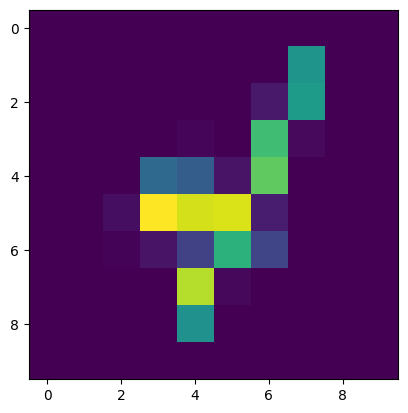

In [21]:
# First, load the template from one of your experiments
# (assuming they all use the same template)
template_path = os.path.join(batch_sweep_dir, "batch_1000", "seed_0", "template.npy")
template_2d = np.load(template_path)
p1, p2 = template_2d.shape

plt.imshow(template_2d)

/tmp/ipykernel_128294/2157201269.py:92: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


Outliers from batch_100 removed for plot
Outliers from batch_1000 removed for plot
Outliers from batch_10000 removed for plot
Outliers from batch_200 removed for plot
Outliers from batch_2000 removed for plot
Outliers from batch_20000 removed for plot
Outliers from batch_50 removed for plot
Outliers from batch_500 removed for plot
Outliers from batch_5000 removed for plot


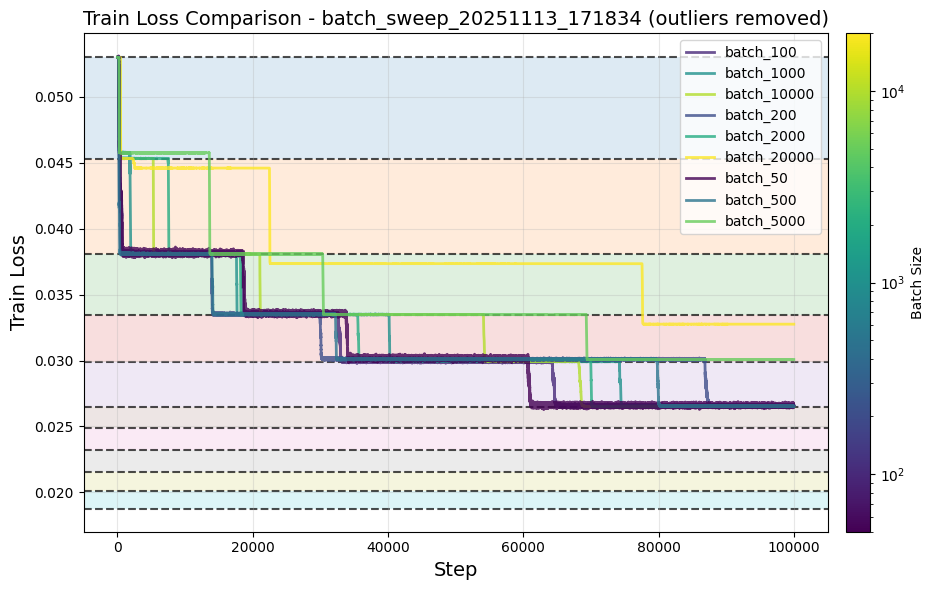

Batch sizes: {'batch_100': 100, 'batch_1000': 1000, 'batch_10000': 10000, 'batch_200': 200, 'batch_2000': 2000, 'batch_20000': 20000, 'batch_50': 50, 'batch_500': 500, 'batch_5000': 5000}
Theory plateau levels:
  Plateau 0: 5.298448e-02
  Plateau 1: 4.530677e-02
  Plateau 2: 3.806381e-02
  Plateau 3: 3.347446e-02
  Plateau 4: 2.991633e-02
  Plateau 5: 2.651234e-02
  Plateau 6: 2.485670e-02
  Plateau 7: 2.321230e-02
  Plateau 8: 2.157320e-02
  Plateau 9: 2.010709e-02
  Plateau 10: 1.874044e-02
  Plateau 11: 1.741158e-02
  Plateau 12: 1.623654e-02
  Plateau 13: 1.508869e-02
  Plateau 14: 1.408196e-02
  Plateau 15: 1.307818e-02
  Plateau 16: 1.214282e-02
  Plateau 17: 1.125079e-02
  Plateau 18: 1.052611e-02
  Plateau 19: 9.803669e-03
  Plateau 20: 9.096431e-03
  Plateau 21: 8.496145e-03
  Plateau 22: 7.900277e-03
  Plateau 23: 7.355611e-03
  Plateau 24: 6.816451e-03
  Plateau 25: 6.309793e-03
  Plateau 26: 5.815373e-03
  Plateau 27: 5.328230e-03
  Plateau 28: 4.855039e-03
  Plateau 29: 4.

In [ ]:
# Example 1: Color by batch_size
color_map, scalar_map, batch_values = create_color_mapping(
    batch_sweep_dir,
    "data.batch_size",
    cmap="viridis",
    log_scale=True,
)

plot_loss_comparison(
    batch_sweep_dir,
    template_2d=template_2d,
    p1=p1,
    p2=p2,
    color_mapping=color_map,
    colorbar_label="Batch Size",
    scalar_map=scalar_map,
    num_theory_lines=10,
    remove_outliers=True,
    log_scale=False,
)


# Print the extracted values to verify
print("Batch sizes:", batch_values)

# Print the theory levels (plateau values)
print("Theory plateau levels:")
for i, level in enumerate(theory_levels):
    print(f"  Plateau {i}: {level:.6e}")

## MLP Scaling Sweep Heatmap

Visualize the relationship between sequence length (k) and hidden dimension (width) for SequentialMLP.

**Sweep parameters:**
- Model: SequentialMLP
- Dimension: 1, p = 10
- k values: 2, 3, 4, 5, 6 (5 values)
- hidden_dim values: 60, 360, 2160, 12960, 77760 (5 values = 10×6¹ through 10×6⁵)
- num_steps varies with k: k=2→50k, k=3→100k, k=4→150k, k=5→200k, k=6→250k
- Total: 25 experiments × 3 seeds = 75 runs

In [4]:
def plot_scaling_heatmap(
    sweep_dir: str,
    k_values: list = [2, 3, 4, 5, 6, 7, 8],
    hidden_dims: list = [60, 360, 2160, 12960, 77760, 466560, 2799360],
    use_log_scale: bool = True,
    save_path: str = None
):    
    """
    Create a heatmap of final train loss vs k and hidden_dim.
    
    Args:
        sweep_dir: Path to the sweep directory
        k_values: List of k values (x-axis)
        hidden_dims: List of hidden dimension values (y-axis)
        use_log_scale: Whether to use log scale for the loss values
        save_path: Optional path to save the figure
    """
    # Load results
    grid, std_grid = load_sweep_results_grid(sweep_dir, k_values, hidden_dims)
    
    # Apply log scale if requested
    plot_grid = np.log10(grid) if use_log_scale else grid
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))    
    
    
    # Create heatmap
    im = ax.imshow(plot_grid, aspect='auto', cmap='viridis', origin='lower')
    
    # Set ticks and labels
    ax.set_xticks(range(len(k_values)))
    ax.set_yticks(range(len(hidden_dims)))
    ax.set_xticklabels(k_values)
    ax.set_yticklabels([f"{h:,}" for h in hidden_dims])
    
    # Labels
    ax.set_xlabel('Sequence Length (k)', fontsize=14)
    ax.set_ylabel('Hidden Dimension (width)', fontsize=14)
    title = 'Final Train Loss: SequentialMLP Scaling'
    if use_log_scale:
        title += ' (log₁₀)'
    ax.set_title(title, fontsize=16, pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar_label = 'log₁₀(Train Loss)' if use_log_scale else 'Train Loss'
    cbar.set_label(cbar_label, fontsize=12)
    
    # Add text annotations

    # Add text annotations
    for i in range(len(hidden_dims)):
        for j in range(len(k_values)):
            if not np.isnan(grid[i, j]):
                text_val = f"{grid[i, j]:.2e}"
                text_color = 'white' if plot_grid[i, j] < plot_grid[~np.isnan(plot_grid)].mean() else 'black'
                ax.text(j, i, text_val, ha='center', va='center', 
                       color=text_color, fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()
    
    return grid

SyntaxError: invalid syntax (2253525129.py, line 69)

NameError: name 'load_sweep_results_grid' is not defined